In [2]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [3]:
import pandas as pd
from urlparse import urlparse
import tldextract
from collections import Counter
import jieba
import json
import math
import numpy as np
from time import time

In [19]:
from gensim.models import Word2Vec, KeyedVectors
model = KeyedVectors.load_word2vec_format('../Words_Embedding/huizhou_model_format_v1.bin', binary=False)

In [6]:
df = pd.read_csv('/Users/nhu2000/projects/SimilarSearch/data/merged/huizhou-v0_1.csv')

In [29]:
df.info()

In [8]:
from urlparse import urlparse
df['domain']  = df.url.map(lambda x:tldextract.extract(x).domain + str('.') + tldextract.extract(x).suffix)

In [9]:
df = df[df['domain'] != 'huaxia.com']

In [11]:
import re
match = re.compile('([a-zA-Z_0-9_=_#_&_/])') #remove letters, numbers, and special characters in the article body
#match = re.compile('([a-zA-Z_0-9])') #remove all of english letters and numbers
def classifier_filters(s):
    return match.sub(r' ', s) 

In [12]:
def filter_combined(x):
    s = x.split()
    r = [t for t in s if (t.strip()) > 0 and t.strip() not in keyword_stop_words]
    t = ' '.join(r)
    ret = classifier_filters(t)
    #print 'before -----', t
    #print 'after ------', ret
    return ret   

In [13]:
huizhou_stop_words = [u'的', u'了', u'在', u'是', u'安徽', u'和', u'有', u'我', u'年', u'上', u'他', u'我们', u'及',
                      u'为', u'与', u'人', u'也', u'于', u'中', u'就', u'都', u'在线', u'等', u'不', u'网站', u'你', 
                      u'一个', u'到', u'之', u'对', u'说', u'进入', u'后', u'月', u'将', u'时', u'又', u'被', u'会员'
                     u'版权', u'论坛', u'以', u'而', u'着', u'下', u'这', u'但', u'要', u'或', u'首页', u'这', u'更',
                     u'地', u'从', u'卡', u'来', '多', u'日', u'她', u'还', u'联系', u'那', u'一处', u'一直', u'个', 
                     u'向', u'并', u'曾', u'这样', u'里', u'合肥', u'推荐', u'专栏', u'相关', u'当前', u'所有', u'中心'
                     u'频道', u'编辑', u'位置', u'第一', u'社区', u'看', '中安', u'安徽省', u'大', u'许可证', u'许可',
                     u'让', u'没有', u'什么', u'其', '请', '该', '用', '积分', u'凤阳', u'一篇', u'版权', u'县', u'这里',
                      u'就是', u'生于', u'他们', u'它', u'男', u'去', u'会', u'由', u'一', u'做', u'所', u'毕业', u'一种',
                     u'协会会员', u'把', u'能', u'至', u'这个', u'自己', u'黄山市', u'出', u'如', u'如',u'可以', u'很',
                     u'成为', u'好', u'先生', u'中国', u'集团', u'江淮', u'网', u'特色', u'全国', u'新', u'作为', u'师专',
                     u'则', u'重要', u'们', u'给', u'这些', u'过', u'安', u'最', u'现在', u'得', u'国家']

s = ' '.join(huizhou_stop_words)
#s = u'444 （）'

In [14]:
import unicodedata
def remove_non_chinese(s):
    r = [c for c in s if unicodedata.category(c).startswith('L')]
#print r
    return ''.join(r)
#print remove_non_chinese(s)

hz_dict = dict(zip(words, fq))

In [15]:
def ch_title_letters_removal(x):
    #print 'coming', x
    t = x.strip('  ')
    if(len(t)) == 0:
        return None
    
    if(len(x) > 0):
        #s = x.strip()
        s = remove_non_chinese(x)
        if len(s) > 0 and s not in huizhou_stop_words:
            return s.strip()
        else:
            return None
    return None

In [205]:
#calculate count using Counter
def map_document_word_cnt(x):
    n = 800
    del_cnt = 0
    count = Counter(x.decode('utf-8').split())
    top_n = count.most_common (n)
    words, cnt = zip(*top_n)
    for word in words:
        ret = ch_title_letters_removal(word)
        if ret == None or len(ret) == 0:
            del count[word]
            del_cnt +=1

    print 'deleted cnt', del_cnt
    top_n = count.most_common (200)
    return top_n

In [204]:
ret = map_document_word_cnt(df.iloc[2]['content_seg'])

for t in ret:
    print t[0], t[1]

In [177]:
top_n = count.most_common(400)
print dict(top_n)

In [17]:
global idx
idx = 0
def map_words_fq(x, normalize=True): 
    global idx
    print idx
    idx += 1
    s = x.decode('utf-8').split()
    #print 'vect ---', len(s), s
    ret = [ch_title_letters_removal(item) for item in s if len(item) > 0 and ch_title_letters_removal(item) != None]
    #print 'ret ---', ret, len(ret)
    count = Counter(x)
    
    #print 'count', len(count)
    
    top_N = count.most_common(100)
        
    words, cnt = zip(*top_N)
    tot = sum(cnt)
    hz_fq = [float(i)*1.0/tot for i in cnt]
    dictionary = dict(zip(words, hz_fq))
        
    #print 'top_100', len(top_100)
    
    if len(top_N) > 0:
        #print 'going ---'
        #*words, cnt = zip(*top_200)
        #return dict(zip(words, cnt))
        return dictionary
    else:
        #print 'warning'
        return None

In [20]:
def map_word2vec_centroid(x):
    global model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in model.vocab]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [model[x] * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return val

In [ ]:
def map_words_fq(x):
    s = x.split()
    ret = [dsi_title_letters_removal(item) for item in s if dsi_title_letters_removal(item) != None]
    count = Counter(ret)
    top_N = count.most_common(100)
    if len(top_N) > 0:
        words, cnt = zip(*top_N)
        tot = sum(cnt)
        dsi_fq = [float(i)*1.0/tot for i in cnt]
        dictionary = dict(zip(words, dsi_fq))
        #print ret
        return dictionary
    else:
        return None

In [26]:
def map_unserialize (x, eval_val = False):
    #print '----- in'
    #print x
    d = dict()
    s = x.strip('{}')
    #s = s.strip('[]')
    ret = s.split(',')
    
    #print ret
    for t in ret:
        r = t.split(':')
        #print r[0], r[1]
        key = eval(r[0].decode('utf-8'))
        d[key] = float(r[1])
    #print len(ret)
    #print 'split -----'
    #print ' '.join(ret)
    return d

In [30]:
df = df.dropna(subset =['s_vec'])

In [149]:
df.info()

In [31]:
t0 = time()
df['words_fq'] = df.s_vec.map(lambda x: map_unserialize(x))
print time() - t0 

In [32]:
t0 = time()
df['w2v_centroid'] = df.words_fq.map(lambda x: map_word2vec_centroid(x))
time() - t0

14.318769931793213

In [35]:
df['content_len'] = df['content_seg'].str.len()

In [36]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline 

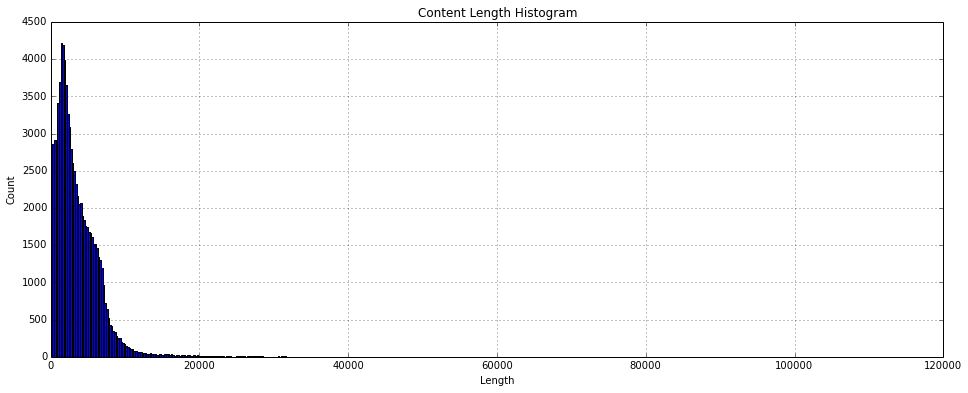

In [37]:
df['content_len'].hist(bins=500, figsize= (16, 6))
plt.title('Content Length Histogram')
plt.xlabel('Length')
plt.ylabel('Count')

In [49]:
test = df[df['content_len'] < 150]

In [50]:
test.info()

In [51]:
for t in test['content']:
    print t

In [52]:
df = df[df['content_len'] >= 150]

In [53]:
df.info()

In [54]:
def get_cosine2(vec1, vec2):
    
    sum1 = np.sum([vec1**2])
    sum2 = np.sum([vec2**2])
    numerator = np.sum([a*b for a,b in zip(vec1,vec2)])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [162]:
t0 = time()
hz_vec = model[u'徽州']*0.3 + model[u'文化']*0.3 + model[u'徽文化']*0.4
df['hzwh_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [163]:
hz_sim = df['hzwh_w2v_sim'].values.argsort()[::-1]

In [164]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzwh_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hzwh_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

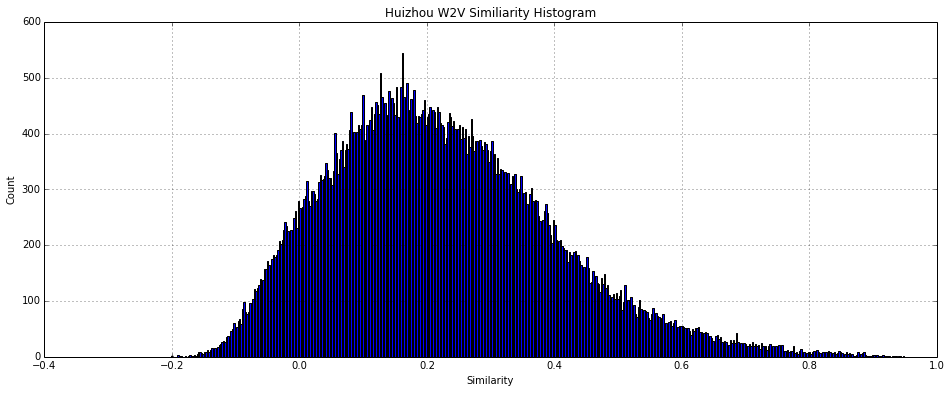

In [140]:
df['hzwh_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [109]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'建筑']*0.5
df['hzjz_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [110]:
hz_sim = df['hzjz_w2v_sim'].values.argsort()[::-1]

In [111]:
df['hwh_w2v_sim'].max()

0.94869370513492457

In [112]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hzjz_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

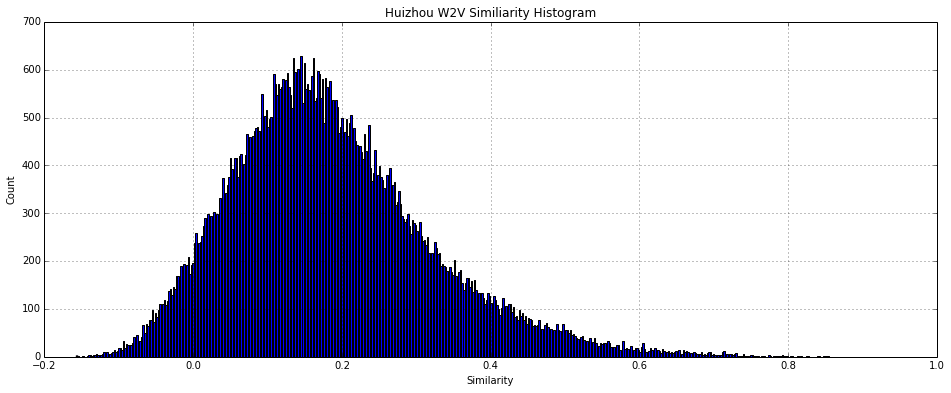

In [141]:
df['hzjz_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [117]:
t0 = time()
hz_vec = model[u'徽州']*0.4 + model[u'继承']*0.3 + model[u'遗产']*0.3
df['ycjc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [118]:
df['ycjc_w2v_sim'].max()

0.87542787530758581

In [119]:
hz_sim = df['ycjc_w2v_sim'].values.argsort()[::-1]

In [120]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['ycjc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

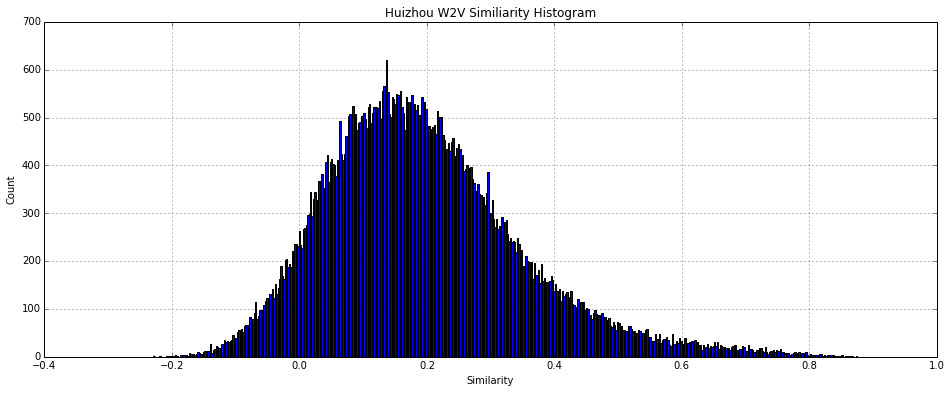

In [142]:
df['ycjc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [121]:
t0 = time()
hz_vec = model[u'徽州']*0.5 + model[u'雕刻']*0.5
df['hzdk_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [122]:
hz_sim = df['hzdk_w2v_sim'].values.argsort()[::-1]

In [123]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hzdk_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

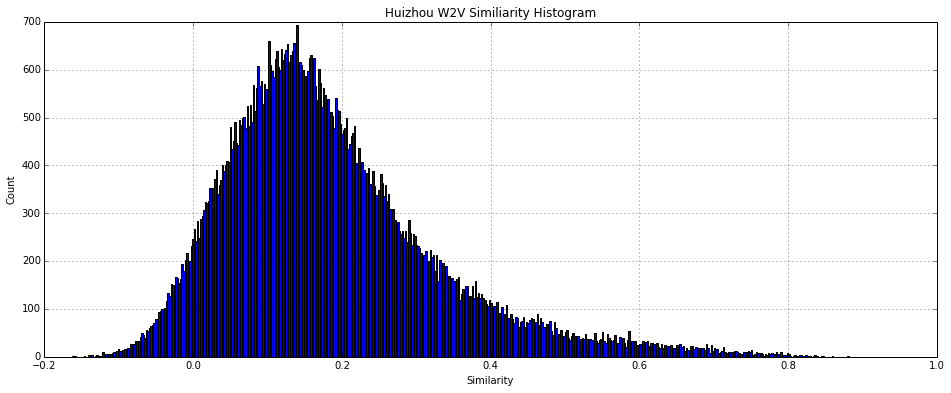

In [143]:
df['hzdk_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [124]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'艺术']*0.5
df['hpys_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [125]:
hz_sim = df['hpys_w2v_sim'].values.argsort()[::-1]

In [126]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hpys_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

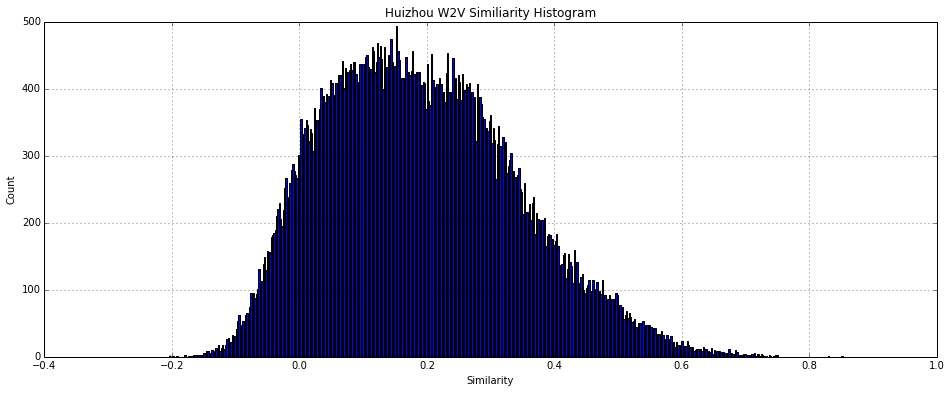

In [144]:
df['hpys_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [127]:
t0 = time()
hz_vec = model[u'徽剧']*0.5 + model[u'徽菜']*0.5
df['hjhc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [128]:
hz_sim = df['hjhc_w2v_sim'].values.argsort()[::-1]

In [130]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hjhc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

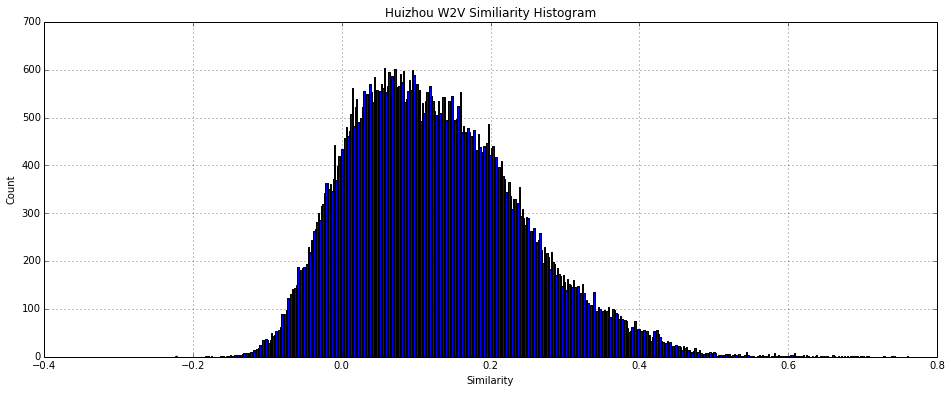

In [145]:
df['hjhc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [131]:
t0 = time()
hz_vec = model[u'徽商']
df['hs_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [132]:
hz_sim = df['hs_w2v_sim'].values.argsort()[::-1]

In [133]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hs_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

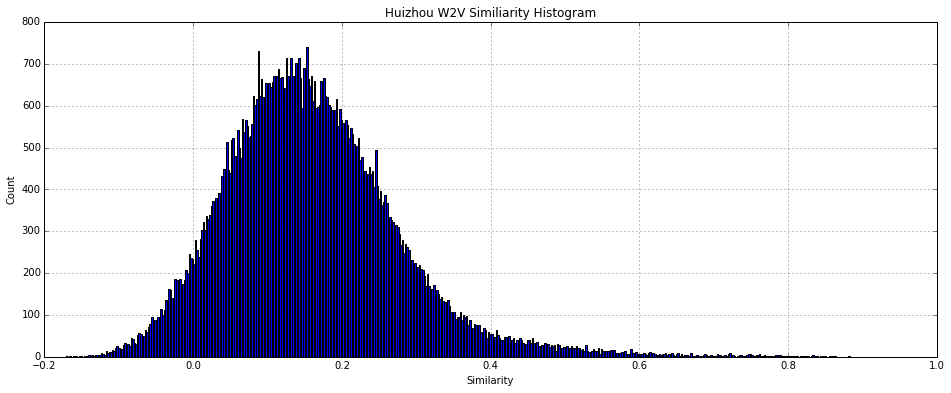

In [146]:
df['hs_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [134]:
t0 = time()
hz_vec = model[u'新安']*0.5 + model[u'理学']*0.5
df['xalx_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [135]:
hz_sim = df['xalx_w2v_sim'].values.argsort()[::-1]

In [136]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['xalx_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

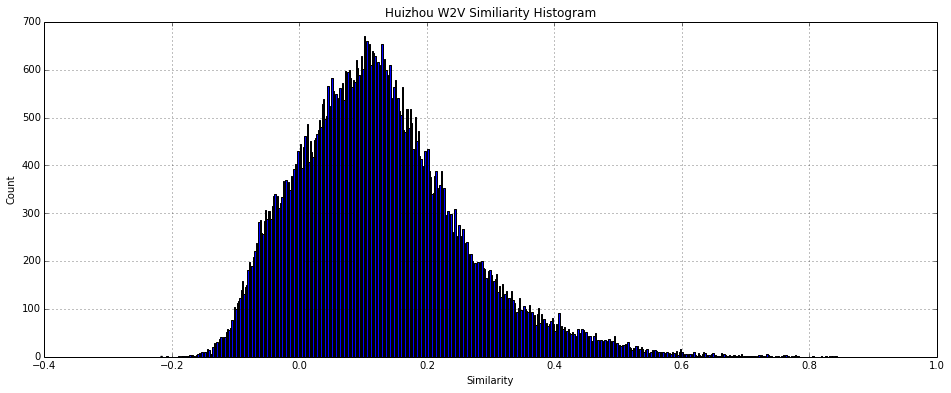

In [147]:
df['xalx_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [137]:
t0 = time()
hz_vec = model[u'徽学']*0.5 + model[u'研究']*0.5
df['hxyj_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [138]:
hz_sim = df['hxyj_w2v_sim'].values.argsort()[::-1]

In [139]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_w2v_sim'] > 0.50 and idx < 50:
        title = df.iloc[i]['title']
        content = df.iloc[i]['summary']
        sim_val = df.iloc[i]['hxyj_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

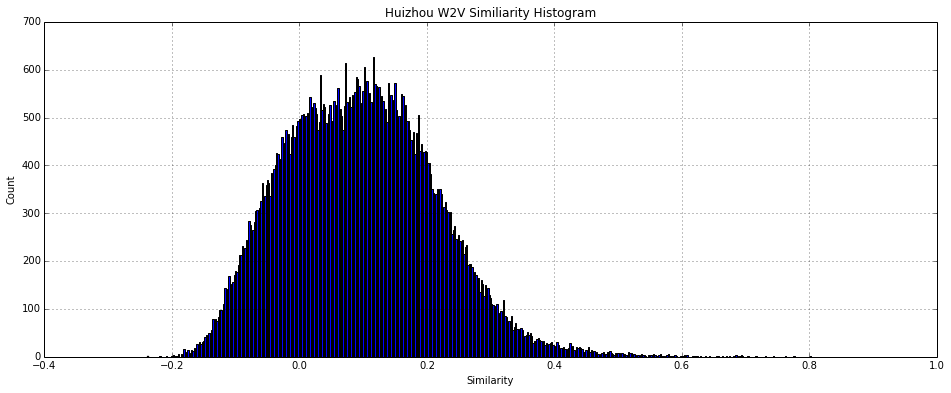

In [148]:
df['hxyj_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [169]:
df.info()

In [168]:
df = df.drop_duplicates(['s_vec'])

In [158]:
def map_serialize(x):
    #print len(x)
    ret = []
    idx = 0
    for v in x:
        #print idx, v
        ret.append(str(v))
        idx += 1
    #print ret
    return ','.join(ret)

In [159]:
df['w2v_centroid_s'] = df.w2v_centroid.map(lambda x: map_serialize(x))

In [171]:
df.head()

,url,title,summary,content,content_seg,s_vec,domain,words_fq,w2v_centroid,content_len,...,hzwh_w2v_sim,hzjz_w2v_sim,ycjc_w2v_sim,hzdk_w2v_sim,hpys_w2v_sim,hjhc_w2v_sim,hs_w2v_sim,xalx_w2v_sim,hxyj_w2v_sim,w2v_centroid_s
0,http://cul.anhuinews.com/system/2016/11/28/007...,洪建华夫妇的竹刻人生,。不久前，我们几名政协委员应邀到正在建设中的黄山市徽派雕刻博物馆参观考察时，洪建华一边介绍新...,谁能想到，洪建华夫妇这对一无学历、二无家传、三无师承的“三无大师”成了省级非物质文化遗产·徽...,谁 能 想到 ， 洪 建华 夫妇 这 对 一 无 学历 、 二 无 家传 、 三无 师承 的...,"{u'竹木': 0.0114285714286, u'洪': 0.0571428571429...",anhuinews.com,"{u'竹木': 0.0114285714286, u'洪': 0.0571428571429...","[-0.0060236, -0.0103621, 0.00755846, -0.000569...",10703,...,0.463720,0.567314,0.573373,0.633446,0.680938,0.424617,0.311315,0.397321,0.291379,"-0.0060236,-0.0103621,0.00755846,-0.000569638,..."
1,http://cul.anhuinews.com/system/2016/11/21/007...,徽州民歌传人操明花校园授艺,。“磨米磨麦，磨米磨麦……”随着教室里传来一阵阵悦耳动听的方言民歌声，操明花正兴致勃勃地教同...,近日，省非物质文化遗产徽州民歌传承人操明花前往休宁县海阳二小、歙县城关小学和徽州区岩寺镇中心...,近日 ， 省非 物质 文化遗产 徽州 民歌 传承 人操 明花 前往 休宁县 海阳 二小 、 ...,"{u'它': 0.0123456790123, u'原生态': 0.012345679012...",anhuinews.com,"{u'它': 0.0123456790123, u'原生态': 0.012345679012...","[-0.0107781, 0.0129855, 0.00413211, 0.00171845...",1264,...,0.565720,0.358653,0.557331,0.468289,0.517698,0.438723,0.306038,0.308822,0.250730,"-0.0107781,0.0129855,0.00413211,0.00171845,-0...."
2,http://cul.anhuinews.com/system/2016/11/03/007...,黄山楹联漫谈,。黄山雄伟奇丽、气势非凡，原省文联主席赖少其说，非有大手笔，不能画黄山。有“二联”站得高，看...,黄山楹联第一人当推明朝诗人余绍祉。他遍历祖国名山大川，见到无数奇峰怪石，却感到抵不上黄山峰林...,黄山 楹联 第一 人当 推 明朝 诗人 余绍祉 。 他 遍历 祖国 名山大川 ， 见到 无数...,"{u'气派': 0.0123456790123, u'名句': 0.012345679012...",anhuinews.com,"{u'气派': 0.0123456790123, u'名句': 0.012345679012...","[-0.0120081, -0.0145887, 0.0144744, -0.0120817...",2028,...,0.255002,0.260202,0.269191,0.340901,0.296441,0.235815,0.191698,0.246864,0.182968,"-0.0120081,-0.0145887,0.0144744,-0.0120817,-0...."
3,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州木雕艺术,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州民居、家具木板和圆木雕刻艺术的简称。木雕在旧属徽州各县分布之广在全国屈指可数，宅院内的屏...,徽州 民居 、 家具 木板 和 圆木 雕刻 艺术 的 简称 。 木雕 在 旧属 徽州 各县 ...,"{u'吉祥图案': 0.0172413793103, u'少数': 0.0172413793...",anhuinews.com,"{u'吉祥图案': 0.0172413793103, u'少数': 0.0172413793...","[-0.0134407, -0.0106611, 0.0100197, -0.0117281...",721,...,0.463754,0.588129,0.565690,0.765616,0.544592,0.325793,0.382593,0.354244,0.263324,"-0.0134407,-0.0106611,0.0100197,-0.0117281,-0...."
4,http://cul.anhuinews.com/system/2016/01/26/007...,徽派雕刻——徽州砖雕艺术,。从早期的简单粗犷、朴素的纹样，逐步演变到后期的繁腹、细致华丽的结构，形成了自己独特的艺术风...,徽州砖雕徽州砖雕的造型，来源于汉画象砖。汉画象砖大都是模印砖坯刻画后入密烧制，嵌窃时再进行修...,徽州 砖雕 徽州 砖雕 的 造型 ， 来源于 汉 画象 砖 。 汉 画象 砖 大都 是 模印...,"{u'一': 0.0106382978723, u'它': 0.0212765957447,...",anhuinews.com,"{u'一': 0.0106382978723, u'它': 0.0212765957447,...","[-0.0147771, -0.0149903, 0.0132143, -0.0146898...",2852,...,0.426712,0.555901,0.473556,0.605832,0.577255,0.312113,0.289483,0.315999,0.203333,"-0.0147771,-0.0149903,0.0132143,-0.0146898,-0...."


In [172]:
df.to_csv('../data/clean/huizhou_web_v1.csv', encoding='utf-8', index=False)

In [165]:
df_out = df[['url', 'title', 'summary', 'w2v_centroid_s', 'hzwh_w2v_sim', 'hzjz_w2v_sim', 'ycjc_w2v_sim', 'hzdk_w2v_sim',
             'hpys_w2v_sim', 'hjhc_w2v_sim', 'hs_w2v_sim', 'xalx_w2v_sim', 'hxyj_w2v_sim']]

In [166]:
df_out.to_csv('../data/clean/huizhou-web-slim_v2.csv', encoding='utf-8', index=False)

In [170]:
df_out.info()

In [211]:
df.info()

In [212]:
df_full_out = df[['url', 'title', 'summary', 's_vec_cnt', 'content', 'content_seg']]

In [213]:
df_full_out.to_csv('/Users/nhu2000/projects/SimilarSearch/data/clean/huizhou_full_v1.1.csv', encoding='utf-8', index=False)

In [173]:
model[u'许村']

array([ -7.58834004e-01,   6.37849987e-01,   2.37314200e+00,
         3.93233001e-01,  -2.31934994e-01,  -4.19292003e-01,
         2.77810004e-02,  -6.70256019e-01,   1.31282401e+00,
        -2.81661004e-01,   1.56625605e+00,   1.19458902e+00,
         9.28260028e-01,   2.15436292e+00,   3.43926013e-01,
         7.05360025e-02,   1.01993299e+00,   1.49849200e+00,
         1.05655801e+00,   6.64417982e-01,  -1.83514905e+00,
        -9.82640028e-01,  -4.84759986e-01,   3.44781011e-01,
         2.77079999e-01,   3.39015990e-01,  -2.10096002e-01,
         4.17811006e-01,  -1.15651500e+00,   7.45559990e-01,
         2.34702206e+00,   5.76422989e-01,  -9.99136984e-01,
        -2.25249410e+00,   1.89790297e+00,  -1.52401996e+00,
        -8.07019994e-02,   7.10281014e-01,   6.56597972e-01,
         5.92401981e-01,   8.31799954e-03,  -6.80337012e-01,
        -3.36429000e-01,   7.28859976e-02,  -7.02839017e-01,
        -1.14953303e+00,   2.14949799e+00,  -1.44978094e+00,
         2.21020997e-01,